# Edge detection with Convolutional Neural Network - Part 2

As suggested [1], let's use the CNN kernel to perform edge detection

Following the naive implementation in [Part 1](CnnEdgeDetection-Keras-Part1.html) ([Workbook](CnnEdgeDetection-Keras-Part1.ipynb)), let's use a more complex deep filter (2D combined Sobel) and a multi-layer (aka. deep learning) network with 2D convolution

Learning goals:
- Learn a multi-layer kernel using machine learning techniques

## Edge detection

References:
1. TBD

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, losses, activations, regularizers, metrics
import tensorview as tv
import seaborn as sns

if True:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Helpers

In [40]:
metricNames = ['loss', 'mean square error', 'Kullback Leibler divergence']
bins = np.arange(0, 256)

def plotHistory(hist, with_validation=False):
    """ Plot a classification history as outputted by Keras """
    fig, axes = plt.subplots(1, 3, figsize=(15,6), sharey=True)
    for m, ax in zip(['loss', 'mean_squared_error', 'kullback_leibler_divergence'], axes):
        ax.semilogy(hist.history[m])
        if with_validation:
            ax.semilogy(hist.history['val_'  + m])
            ax.legend(('train', 'valid'))
        ax.set_title(m)
        ax.grid()
        
def plotHeatMap(X, classes='auto', title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None,
               vmin=None, vmax=None, cbar=True):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, 
                     fmt=fmt, vmin=vmin, vmax=vmax, cbar=cbar, cmap=plt.cm.bwr, ax=ax) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def predictUntilLayer(model, layerIndex, data):
    """ Execute prediction on a portion of the model """
    intermediateModel = models.Model(inputs=model.input,
                                 outputs=model.layers[layerIndex].output)
    return intermediateModel.predict(data)

This implementation could be vastly improved but that's not the goal of this tutorial

## Baseline image with OpenCV

Let's create baseline train and test images for our machine learning using OpenCV's __Sobel filter on horizontal and vertical edges__

Dot not get confused with classification problems on a full image like dog vs. cat. In this later case, many more training and test images are necessary

Let's use an image of the [Train Jaune](https://www.pyrenees-cerdagne.com/decouvrir/le-train-jaune/le-parcours) (Yellow train) as training dataset, it is statistically better than the sharp Matterhorn view.

In [10]:
matterhornGray = cv2.imread('assets/Matterhorn_1024.JPG', cv2.IMREAD_GRAYSCALE)
forestGray = cv2.imread('assets/Forest_2048.jpg', cv2.IMREAD_GRAYSCALE)

imageNChannels = 1

In Part 1, the filter to learn was a linear filter with a 2D convolution whose kernel is 3 x 3.
In this Part 2, we will use the combined 2D Sobel filter that is no longer linear as the horizontal and vertical contributions are combined through a quadratic mean. The purpose is to show the potential of deep learning to learn any function, including non linear.

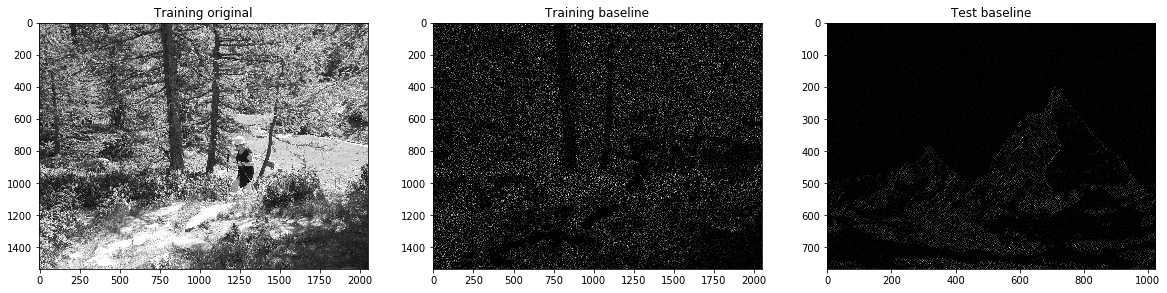

In [11]:
def edgeFilter3(img):
    return cv2.Sobel(img, cv2.CV_8U, 1, 1, ksize=3)

matterhornEdges3 = edgeFilter3(matterhornGray)
forestEdges3 = edgeFilter3(forestGray)

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.title('Training original')
plt.imshow(forestGray, cmap='gray');
plt.subplot(1,3,2)
plt.title('Training baseline')
plt.imshow(forestEdges3, cmap='gray');
plt.subplot(1,3,3)
plt.imshow(matterhornEdges3, cmap='gray');
plt.title('Test baseline');

## Using a deep-learning pipeline as a filter

Using a simple two layer CNN to perform the filter composed here above.

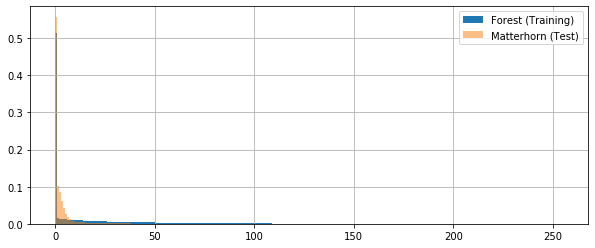

In [33]:
plt.figure(figsize=(10, 4))
plt.hist(forestEdges3.ravel(), bins, alpha=1.0, density=True)
plt.hist(matterhornEdges3.ravel(), bins, alpha=0.5, density=True)
plt.legend(('Forest (Training)', 'Matterhorn (Test)'));
plt.grid()

### Prepare data

Train data is reshaped to be processed in squares of 64 x 64

In [13]:
trainHeight, trainWidth = 64, 64
inputBatchShape = (-1, trainHeight, trainWidth, imageNChannels)
trainImage  = forestGray.reshape(inputBatchShape) / 255.
# Labels
outPutBatchShape = (-1, (trainHeight-2) * (trainWidth-2), imageNChannels)
trainLabels = forestEdges3.reshape(inputBatchShape)
trainLabels = trainLabels[:, 1:-1, 1:-1,:].reshape(outPutBatchShape) / 255.
trainImage.shape

(768, 64, 64, 1)

### Model architecture and fit

Model is made of two convolutions of 3 x 3, the output of the convolution is not squashed (no activation), and is combined by a Neuron (Dense layer of 1 item)

In [ ]:
nEpochs = 4000
batchSize = 128
nConv = 8
nHidden = 32

model1 = models.Sequential([
    layers.Conv2D(nConv, (3, 3), # activation=activations.relu, # 2D convolutions
                input_shape=(None, None, imageNChannels)),
             #   bias_regularizer=regularizers.l1(0.001),
             #   kernel_regularizer=regularizers.l1(0.001)), 
    layers.LeakyReLU(),
    layers.Reshape((-1, nConv)), 
    layers.Dropout(0.05),
    layers.Dense(nHidden), #activation=activations.relu,      # Hidden
            #   bias_regularizer=regularizers.l1(0.001),
            #   kernel_regularizer=regularizers.l1(0.001)), 
    layers.LeakyReLU(),
    layers.Dense(1, activation=activations.linear,          # Combine
               bias_regularizer=regularizers.l1(0.0001),
               kernel_regularizer=regularizers.l1(0.0001))
], 'model1')

model1.compile(optimizer='adam',
              loss= losses.mse,
              metrics=[metrics.mse, metrics.kullback_leibler_divergence])

model1.summary()

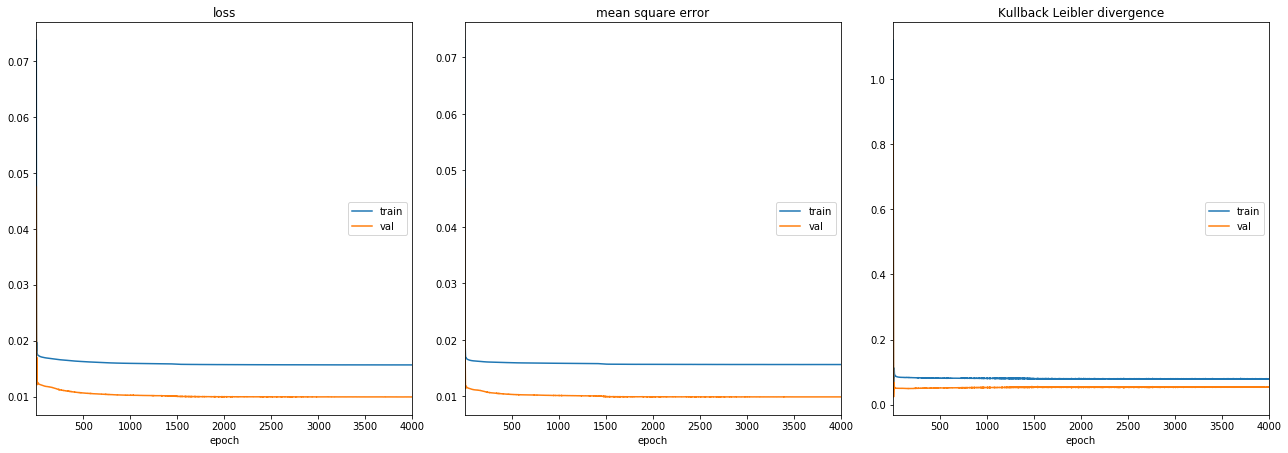

In [20]:
tv_plot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,6), columns=3, iter_num=nEpochs, wait_num=10)
hist1 = model1.fit(trainImage, trainLabels, 
                   epochs=nEpochs, batch_size=batchSize, 
                   validation_split=0.2, 
                   verbose=0,
                  callbacks=[tv_plot])

In [21]:
#plotHistory(hist1, True)

### Test the model

Test image : loss (MSE + regularization) = 2.550e-05, Mean Sq. Error = 2.414e-19


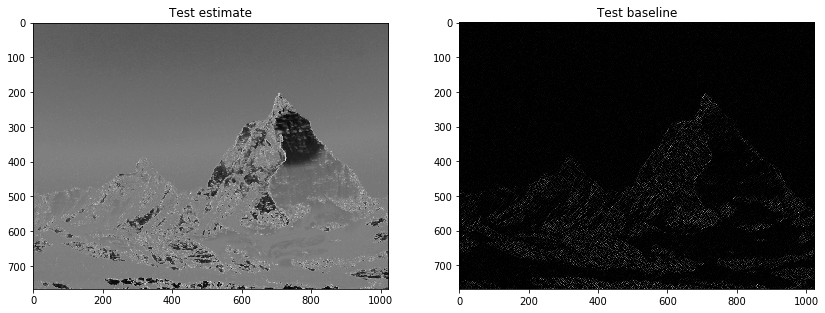

In [22]:
testImageHeight = 768
testImageWidth = 1024
testImage = matterhornGray.reshape(1, testImageHeight, testImageWidth, 1) / 255.
testEst = model1.predict(testImage)
testEstEdges = np.clip((testEst.reshape(testImageHeight-2, testImageWidth-2)) * 255., 0, 255.)

eval1 = model1.evaluate(testImage, testEstEdges.reshape(1, -1, 1)  / 255., verbose=0)
print("Test image : loss (MSE + regularization) = %.3e, Mean Sq. Error = %.3e" % (eval1[0], eval1[1]))

plt.figure(figsize=(14, 8))
plt.subplot(1,2,1)
plt.imshow(testEstEdges, cmap='gray');
plt.title('Test estimate');
plt.subplot(1,2,2)
plt.imshow(matterhornEdges3, cmap='gray');
plt.title('Test baseline');

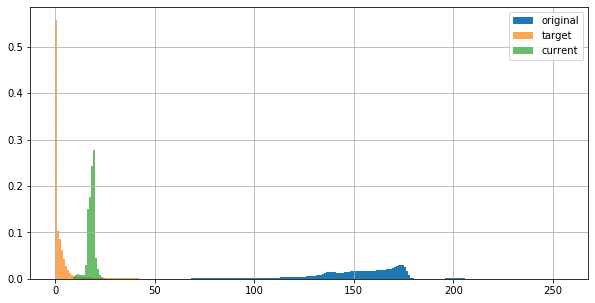

In [28]:
plt.figure(figsize=(10, 5))
plt.hist((testImage.reshape(-1) * 255), bins, density=True, label='original')
plt.hist(matterhornEdges3.reshape(-1), bins, density=True, alpha=0.7, label='target')
plt.hist(testEstEdges.reshape(-1), bins, density=True, alpha=0.7, label='current')
plt.legend()
plt.grid();

#### Intermediate features (activations)

(1, 766, 1022, 8)

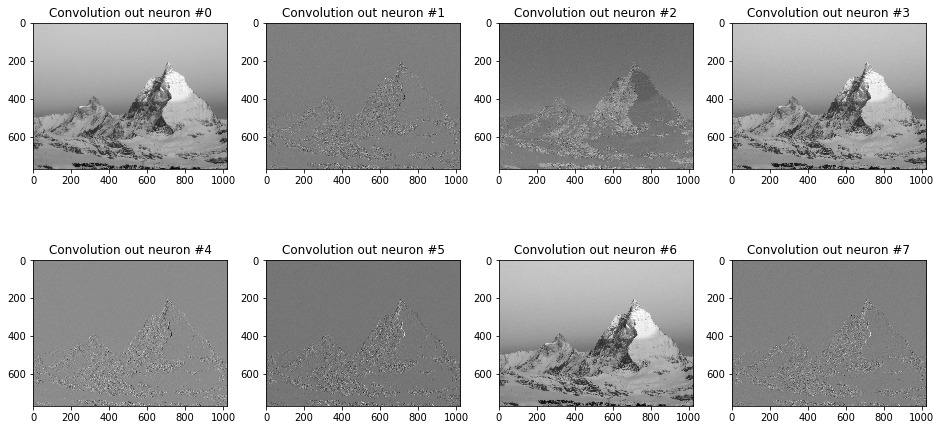

In [46]:
testConvol = predictUntilLayer(model1, 0, testImage)

fig, axes = plt.subplots(2, nConv // 2, figsize=(16, 8))
for i,ax in enumerate(axes.ravel()):
    ax.imshow(testConvol[0,:,:,i], cmap='gray');
    ax.set_title('Convolution out neuron #%d' % i);

testConvol.shape

#### Model coefficients

Convolution biases = -1.001e+00, -2.626e-02
Dense #2 bias = 6.410e-02


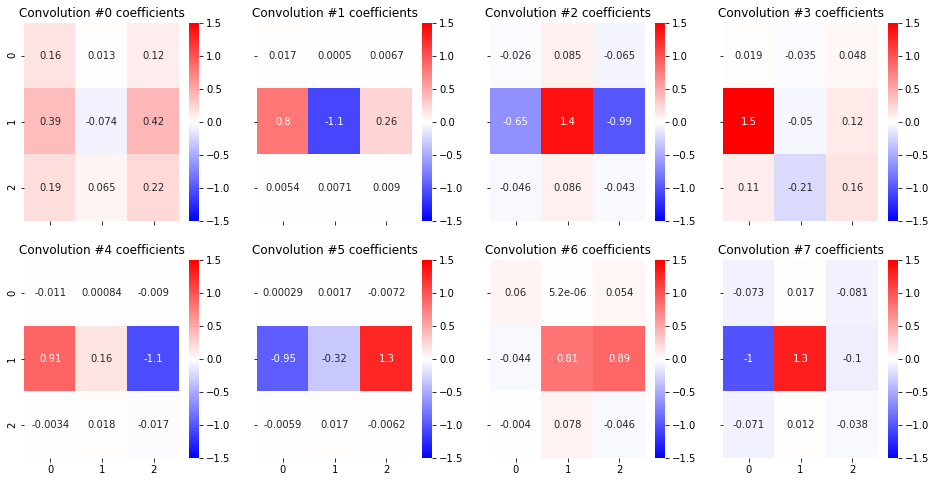

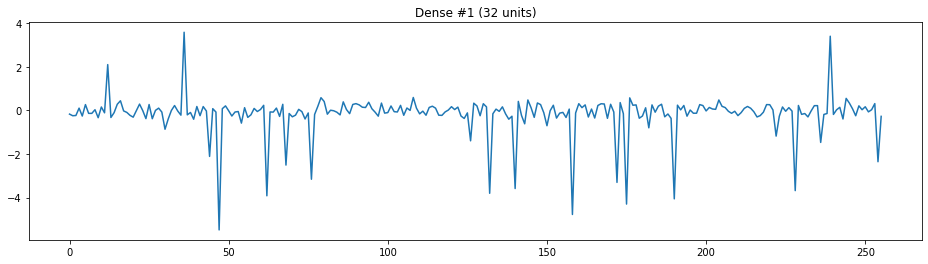

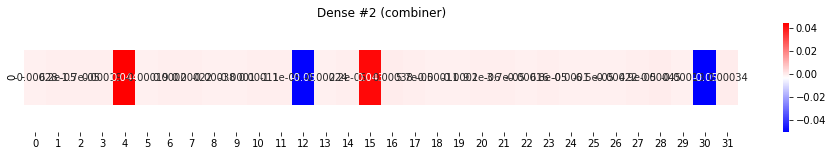

In [47]:
weights1 = model1.get_weights()
fig, axes = plt.subplots(2, nConv // 2, figsize=(16, 8), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    plotHeatMap(np.array(weights1[0]).reshape(3, 3, nConv)[:,:,i], ax=ax, title='Convolution #%d coefficients' % i, 
                vmin=-1.5, vmax=1.5)
print('Convolution biases = %.3e, %.3e' % (weights1[1][0], weights1[1][1]))
fig, ax = plt.subplots(1,1, figsize=(16, 4), sharey=True)
ax.plot(weights1[2].ravel())
ax.set_title('Dense #1 (32 units)')
#print('Dense #2 bias = %.3e' % (weights1[3][0]))
fig, ax = plt.subplots(1,1, figsize=(16, 2), sharey=True)
plotHeatMap(weights1[4].reshape(1, -1), title='Dense #2 (combiner)', ax=ax)
print('Dense #2 bias = %.3e' % (weights1[5][0]))